# Data Analysis over transactions

Transactions represent the biggest slice of information we have about clients, for this reason we will try to exploit it as first resource to get insights over the clients and their aggregation into clusters according to their behaviour over time into the banking system. 


In [26]:
import pandas as pd
import numpy as np

from IPython.display import Image 

In [30]:
import pickle
with open('./crafted/df_cleaned.pickle', 'rb') as handle:
    data_object = pickle.load(handle)

account_data = data_object[data_object['account_id']==1]
x = account_data[['date_days_from_last_trans', 'date']].iloc[40:70, :]
x#[x['date_days_from_last_trans']<0]

x.sort_values('date')

,date_days_from_last_trans,date
trans_id,,
58,-1195,1995-09-05
59,30,1995-10-05
60,31,1995-11-05
61,30,1995-12-05
62,31,1996-01-05
63,31,1996-02-05
64,29,1996-03-05
65,31,1996-04-05
66,30,1996-05-05


In [18]:
df = pd.read_csv('transactions.csv', index_col=['trans_id'], parse_dates=['date'])
df

/home/one/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/one/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,account_id,date,type,operation,amount,balance,k_symbol,bank,account
trans_id,,,,,,,,,
1,1,1995-03-24,PRIJEM,VKLAD,1000,1000,NaN,NaN,NaN
5,1,1995-04-13,PRIJEM,PREVOD Z UCTU,3679,4679,NaN,AB,41403269.0
6,1,1995-05-13,PRIJEM,PREVOD Z UCTU,3679,20977,NaN,AB,41403269.0
7,1,1995-06-13,PRIJEM,PREVOD Z UCTU,3679,26835,NaN,AB,41403269.0
8,1,1995-07-13,PRIJEM,PREVOD Z UCTU,3679,30415,NaN,AB,41403269.0
...,...,...,...,...,...,...,...,...,...
3682983,10451,1998-08-31,PRIJEM,NaN,62,17300,UROK,NaN,NaN
3682984,10451,1998-09-30,PRIJEM,NaN,49,13442,UROK,NaN,NaN
3682985,10451,1998-10-31,PRIJEM,NaN,34,10118,UROK,NaN,NaN


In [19]:
print(f'There are {df.shape[0]} transactions in this dataset. Initial information about each transaction is stored as a tuple of {len(df.columns)} columns, namely:')
print('\n',np.array(df.columns))

There are 1056320 transactions in this dataset. Initial information about each transaction is stored as a tuple of 9 columns, namely:

 ['account_id' 'date' 'type' 'operation' 'amount' 'balance' 'k_symbol'
 'bank' 'account']


First let's check for **TYPES AND NULL VALUES** for each column:

In [20]:
print('Amount of null values per each column: \n')
for i, col in enumerate(df.columns):
    column_number = i
    column_name = col
    non_null_count = df.shape[0] - df[column_name].notnull().sum()
    dtype = df[column_name].dtype
    print(f'{column_number} -> {column_name} -> {non_null_count} ({dtype})')
  

Amount of null values per each column: 

0 -> account_id -> 0 (int64)
1 -> date -> 0 (datetime64[ns])
2 -> type -> 0 (object)
3 -> operation -> 183114 (object)
4 -> amount -> 0 (int64)
5 -> balance -> 0 (int64)
6 -> k_symbol -> 481881 (object)
7 -> bank -> 782812 (object)
8 -> account -> 760931 (float64)


In [21]:
print('Columns that have null values and cardinalities:')

nulls = df.isnull().sum()
nulls[nulls != 0]

Columns that have null values and cardinalities:


operation    183114
k_symbol     481881
bank         782812
account      760931
dtype: int64

In [22]:
df = df.sort_values(by=['account_id', 'date'])

## Analysis and wrangling over field: 'date'

We exploit the date field by splitting it into different informative fields about time.

In [23]:
sample_date = df['date'].iloc[0]

print(sample_date)
print(sample_date.dayofweek)
print(sample_date.day)
print(sample_date.week)
print(sample_date.month)
print(sample_date.year)


1995-03-24 00:00:00
4
24
12
3
1995


In [24]:
dayofweek = df['date'].map(lambda date: date.dayofweek)
day = df['date'].map(lambda date: date.day)
week = df['date'].map(lambda date: date.week)
month = df['date'].map(lambda date: date.month)
year = df['date'].map(lambda date: date.year)

data = [dayofweek, day, week, month, year]
headers = ['date_'+x for x in ['dayofweek', 'day', 'week', 'month', 'year']]
date = pd.concat(data, axis=1, keys=headers)
date.head()

,date_dayofweek,date_day,date_week,date_month,date_year
trans_id,,,,,
1,4,24,12,3,1995
5,3,13,15,4,1995
199,6,23,16,4,1995
3530438,6,30,17,4,1995
6,5,13,19,5,1995


In [25]:
date['date_year'].value_counts()

1998    322277
1997    284409
1996    196779
1995    133022
1994     91628
1993     28205
Name: date_year, dtype: int64

In [26]:
date['date_year'] = date['date_year']-1993
date.head()

,date_dayofweek,date_day,date_week,date_month,date_year
trans_id,,,,,
1,4,24,12,3,2
5,3,13,15,4,2
199,6,23,16,4,2
3530438,6,30,17,4,2
6,5,13,19,5,2


In [28]:
time_between_last_trans = pd.Series(dtype='<M8[ns]')
for account_id in df['account_id'].unique():
    account_trans = df[df['account_id']==account_id]['date']
    shifted_trans = account_trans.shift(1, fill_value = account_trans.iloc[0])
    time_between_last_trans = pd.concat([time_between_last_trans,(account_trans-shifted_trans)])
time_between_last_trans = time_between_last_trans.map(lambda date: date.days)
date['date_days_from_last_trans'] = time_between_last_trans
date.head()



,date_dayofweek,date_day,date_week,date_month,date_year,date_days_from_last_trans
trans_id,,,,,,
1,4,24,12,3,2,0
5,3,13,15,4,2,20
199,6,23,16,4,2,10
3530438,6,30,17,4,2,7
6,5,13,19,5,2,13


In [34]:
field_name = 'date'

for column in date.columns:
    df.insert(
        df.columns.get_loc(field_name),
        column.lower(),
        date[column]
    )
#df = df.drop(columns=[field_name])
df

,account_id,date_dayofweek,date_day,date_week,date_month,date_year,date_days_from_last_trans,date,type,operation,amount,balance,k_symbol,bank,account
trans_id,,,,,,,,,,,,,,,
1,1,4,24,12,3,2,0,1995-03-24,PRIJEM,VKLAD,1000,1000,NaN,NaN,NaN
5,1,3,13,15,4,2,20,1995-04-13,PRIJEM,PREVOD Z UCTU,3679,4679,NaN,AB,41403269.0
199,1,6,23,16,4,2,10,1995-04-23,PRIJEM,VKLAD,12600,17279,NaN,NaN,NaN
3530438,1,6,30,17,4,2,7,1995-04-30,PRIJEM,NaN,19,17298,UROK,NaN,NaN
6,1,5,13,19,5,2,13,1995-05-13,PRIJEM,PREVOD Z UCTU,3679,20977,NaN,AB,41403269.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431284,11382,2,2,49,12,5,2,1998-12-02,VYDAJ,VYBER,25600,41114,NaN,NaN,NaN
3431109,11382,3,10,50,12,5,8,1998-12-10,PRIJEM,PREVOD Z UCTU,46248,87362,NaN,QR,62510245.0
3431152,11382,4,25,52,12,5,15,1998-12-25,VYDAJ,VYBER,6300,81062,NaN,NaN,NaN


In [38]:
df[['account_id', 'date', 'date_days_from_last_trans']].sort_values(['account_id', 'date']).iloc[0:30,:]

,account_id,date,date_days_from_last_trans
trans_id,,,
1,1,1995-03-24,0
5,1,1995-04-13,20
199,1,1995-04-23,10
3530438,1,1995-04-30,7
6,1,1995-05-13,13
200,1,1995-05-23,10
3530439,1,1995-05-31,8
7,1,1995-06-13,13
201,1,1995-06-22,9


We're going to keep the date field in order to make consecutive transactions easier to group.

In [13]:
account_id = df['account_id'].unique()[0]
df[df['account_id']==account_id]

,account_id,date_dayofweek,date_day,date_week,date_month,date_year,date_days_from_last_trans,date,type,operation,amount,balance,k_symbol,bank,account
trans_id,,,,,,,,,,,,,,,
1,1,4,24,12,3,2,0,1995-03-24,PRIJEM,VKLAD,1000,1000,NaN,NaN,NaN
5,1,3,13,15,4,2,20,1995-04-13,PRIJEM,PREVOD Z UCTU,3679,4679,NaN,AB,41403269.0
199,1,6,23,16,4,2,10,1995-04-23,PRIJEM,VKLAD,12600,17279,NaN,NaN,NaN
3530438,1,6,30,17,4,2,7,1995-04-30,PRIJEM,NaN,19,17298,UROK,NaN,NaN
6,1,5,13,19,5,2,13,1995-05-13,PRIJEM,PREVOD Z UCTU,3679,20977,NaN,AB,41403269.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3530481,1,0,30,49,11,5,0,1998-11-30,PRIJEM,NaN,67,16702,UROK,NaN,NaN
230,1,3,3,49,12,5,3,1998-12-03,VYDAJ,VYBER,4500,12187,NaN,NaN,NaN
97,1,5,5,49,12,5,2,1998-12-05,VYDAJ,PREVOD NA UCET,2452,9735,SIPO,YZ,87144583.0


In [14]:
def clean_date_field(df):
    # extracting series of potentially interesting fields from the date
    dayofweek = df['date'].map(lambda date: date.dayofweek)
    day = df['date'].map(lambda date: date.day)
    week = df['date'].map(lambda date: date.week)
    month = df['date'].map(lambda date: date.month)
    year = df['date'].map(lambda date: date.year)

    # renaming headers and concatenating series	
    data = [dayofweek, day, week, month, year]
    headers = ['date_'+x for x in ['dayofweek', 'day', 'week', 'month', 'year']]
    date = pd.concat(data, axis=1, keys=headers)

    # rescaling year information
    date['date_year'] = date['date_year']-1993

    # extracting information relative to the time passed from the last transaction for the specific account
    time_between_last_trans = pd.Series(dtype='<M8[ns]')
    for account_id in df['account_id'].unique():
        account_trans = df[df['account_id']==account_id]['date']
        shifted_trans = account_trans.shift(1, fill_value = account_trans.iloc[0])
        time_between_last_trans = pd.concat([time_between_last_trans,(account_trans-shifted_trans)])
    time_between_last_trans = time_between_last_trans.map(lambda date: date.days)
    date['date_days_from_last_trans'] = time_between_last_trans
    
    # adding new fields as columns of the original df
    field_name = 'date'
    for column in date.columns:
        df.insert(
            df.columns.get_loc(field_name),
            column.lower(),
            date[column]
        )
        
    return df

## Analysis and wrangling over field: 'type'

In [15]:
df['type'] = df['type'].map({'PRIJEM': 'Credit', 'VYDAJ': 'Withdrawal', 'VYBER': 'Withdrawal in cash'})

We can split the 'type' feature into different columns, leaving the 'Credit' value as it is, and considering two columns named 'Withdrawal' and 'Withdrawal Cash', so that we have the following configurations:
* credit: 100
* withdrawal: 010
* withdrawal with cash: 011

in order to give correlation between withdrawal with and without cash (they're actually the same operation).

In [16]:
field_name = 'type'

one_hot = pd.get_dummies(df[field_name], prefix=field_name)
one_hot.columns = ['type_credit', 'type_withdrawal', 'type_cash']
one_hot.loc[one_hot['type_cash']==1, 'type_withdrawal'] = 1
for column in one_hot.columns:
    df.insert(
        df.columns.get_loc(field_name),
        column.lower(),
        one_hot[column]
    )
df = df.drop(columns=[field_name])
df

,account_id,date_dayofweek,date_day,date_week,date_month,date_year,date_days_from_last_trans,date,type_credit,type_withdrawal,type_cash,operation,amount,balance,k_symbol,bank,account
trans_id,,,,,,,,,,,,,,,,,
1,1,4,24,12,3,2,0,1995-03-24,1,0,0,VKLAD,1000,1000,NaN,NaN,NaN
5,1,3,13,15,4,2,20,1995-04-13,1,0,0,PREVOD Z UCTU,3679,4679,NaN,AB,41403269.0
199,1,6,23,16,4,2,10,1995-04-23,1,0,0,VKLAD,12600,17279,NaN,NaN,NaN
3530438,1,6,30,17,4,2,7,1995-04-30,1,0,0,NaN,19,17298,UROK,NaN,NaN
6,1,5,13,19,5,2,13,1995-05-13,1,0,0,PREVOD Z UCTU,3679,20977,NaN,AB,41403269.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431284,11382,2,2,49,12,5,2,1998-12-02,0,1,0,VYBER,25600,41114,NaN,NaN,NaN
3431109,11382,3,10,50,12,5,8,1998-12-10,1,0,0,PREVOD Z UCTU,46248,87362,NaN,QR,62510245.0
3431152,11382,4,25,52,12,5,15,1998-12-25,0,1,0,VYBER,6300,81062,NaN,NaN,NaN


In [17]:
def clean_type_field(df):
    # translating type names to make them better readable
    df['type'] = df['type'].map({'PRIJEM': 'Credit', 'VYDAJ': 'Withdrawal', 'VYBER': 'Withdrawal in cash'})

    # Split the type into three columns, and simplify with the following values:
    #   - credit: 100
    #   - withdrawal: 010
    #   - withdrawal with cash: 011

    field_name = 'type'
    one_hot = pd.get_dummies(df[field_name], prefix=field_name)
    one_hot.columns = ['type_credit', 'type_withdrawal', 'type_cash']
    one_hot.loc[one_hot['type_cash']==1, 'type_withdrawal'] = 1
    for column in one_hot.columns:
        df.insert(
            df.columns.get_loc(field_name),
            column.lower(),
            one_hot[column]
        )

    # removing the type column
    df = df.drop(columns=[field_name])

    return df

## Analysis and wrangling over field: 'operation'

In [18]:
df['operation'] = df['operation'].map({
    'VKLAD': 'Credit in cash', 
    'PREVOD Z UCTU': 'Collection from another bank', 
    'PREVOD NA UCET': 'Remittance to another bank',
    'VYBER': 'Withdrawal in cash',
    'VYBER KARTOU': 'Credit Card Withdrawal'
})

In [19]:
df['operation'].unique()

array(['Credit in cash', 'Collection from another bank', nan,
       'Withdrawal in cash', 'Remittance to another bank',
       'Credit Card Withdrawal'], dtype=object)

In [20]:
df['operation'].value_counts()

Withdrawal in cash              434918
Remittance to another bank      208283
Credit in cash                  156743
Collection from another bank     65226
Credit Card Withdrawal            8036
Name: operation, dtype: int64

In [21]:
field_name = 'operation'

one_hot = pd.get_dummies(df[field_name], prefix=field_name)
one_hot.columns = ['op_credit_from_bank', 'op_withdrawal_from_card', 'op_credit_in_cash', 'op_withdrawal_to_bank', 'op_withdrawal_in_cash']
for column in one_hot.columns:
    df.insert(
        df.columns.get_loc(field_name),
        column.lower(),
        one_hot[column]
    )
df = df.drop(columns=[field_name])
df

,account_id,date_dayofweek,date_day,date_week,date_month,date_year,date_days_from_last_trans,date,type_credit,type_withdrawal,...,op_credit_from_bank,op_withdrawal_from_card,op_credit_in_cash,op_withdrawal_to_bank,op_withdrawal_in_cash,amount,balance,k_symbol,bank,account
trans_id,,,,,,,,,,,,,,,,,,,,,
1,1,4,24,12,3,2,0,1995-03-24,1,0,...,0,0,1,0,0,1000,1000,NaN,NaN,NaN
5,1,3,13,15,4,2,20,1995-04-13,1,0,...,1,0,0,0,0,3679,4679,NaN,AB,41403269.0
199,1,6,23,16,4,2,10,1995-04-23,1,0,...,0,0,1,0,0,12600,17279,NaN,NaN,NaN
3530438,1,6,30,17,4,2,7,1995-04-30,1,0,...,0,0,0,0,0,19,17298,UROK,NaN,NaN
6,1,5,13,19,5,2,13,1995-05-13,1,0,...,1,0,0,0,0,3679,20977,NaN,AB,41403269.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431284,11382,2,2,49,12,5,2,1998-12-02,0,1,...,0,0,0,0,1,25600,41114,NaN,NaN,NaN
3431109,11382,3,10,50,12,5,8,1998-12-10,1,0,...,1,0,0,0,0,46248,87362,NaN,QR,62510245.0
3431152,11382,4,25,52,12,5,15,1998-12-25,0,1,...,0,0,0,0,1,6300,81062,NaN,NaN,NaN


In [22]:
def clean_operation_field(df):
    # translating operation names to make them better readable
    df['operation'] = df['operation'].map({
        'VKLAD': 'Credit in cash', 
        'PREVOD Z UCTU': 'Collection from another bank', 
        'PREVOD NA UCET': 'Remittance to another bank',
        'VYBER': 'Withdrawal in cash',
        'VYBER KARTOU': 'Credit Card Withdrawal'
    })

    # transforming operation values into one-hot vectors
    field_name = 'operation'
    one_hot = pd.get_dummies(df[field_name], prefix=field_name)
    one_hot.columns = ['op_credit_from_bank', 'op_withdrawal_from_card', 'op_credit_in_cash', 'op_withdrawal_to_bank', 'op_withdrawal_in_cash']
    for column in one_hot.columns:
        df.insert(
            df.columns.get_loc(field_name),
            column.lower(),
            one_hot[column]
        )
    
    # removing the operation column
    df = df.drop(columns=[field_name])

    return df

## Analysis and wrangling over field: 'k_symbol'

In [23]:
df['k_symbol'].unique()

array([nan, 'UROK', 'SLUZBY', 'SIPO', 'UVER', ' ', 'POJISTNE', 'DUCHOD',
       'SANKC. UROK'], dtype=object)

In [24]:
df['k_symbol'] = df['k_symbol'].replace(' ', np.NaN)
df['k_symbol'].unique()

array([nan, 'UROK', 'SLUZBY', 'SIPO', 'UVER', 'POJISTNE', 'DUCHOD',
       'SANKC. UROK'], dtype=object)

In [25]:
df['k_symbol'] = df['k_symbol'].map({
    'SIPO': 'Household Payment', 
    'SLUZBY': 'Payment of Statement', 
    'UVER': 'Loan Payment',
    'POJISTNE': 'Insurance Payment',
    'DUCHOD': 'Old-age Pension Payment',
    'UROK': 'Interest Credited',
    'SANKC. UROK': 'Sanction Interest'
})
df

,account_id,date_dayofweek,date_day,date_week,date_month,date_year,date_days_from_last_trans,date,type_credit,type_withdrawal,...,op_credit_from_bank,op_withdrawal_from_card,op_credit_in_cash,op_withdrawal_to_bank,op_withdrawal_in_cash,amount,balance,k_symbol,bank,account
trans_id,,,,,,,,,,,,,,,,,,,,,
1,1,4,24,12,3,2,0,1995-03-24,1,0,...,0,0,1,0,0,1000,1000,NaN,NaN,NaN
5,1,3,13,15,4,2,20,1995-04-13,1,0,...,1,0,0,0,0,3679,4679,NaN,AB,41403269.0
199,1,6,23,16,4,2,10,1995-04-23,1,0,...,0,0,1,0,0,12600,17279,NaN,NaN,NaN
3530438,1,6,30,17,4,2,7,1995-04-30,1,0,...,0,0,0,0,0,19,17298,Interest Credited,NaN,NaN
6,1,5,13,19,5,2,13,1995-05-13,1,0,...,1,0,0,0,0,3679,20977,NaN,AB,41403269.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431284,11382,2,2,49,12,5,2,1998-12-02,0,1,...,0,0,0,0,1,25600,41114,NaN,NaN,NaN
3431109,11382,3,10,50,12,5,8,1998-12-10,1,0,...,1,0,0,0,0,46248,87362,NaN,QR,62510245.0
3431152,11382,4,25,52,12,5,15,1998-12-25,0,1,...,0,0,0,0,1,6300,81062,NaN,NaN,NaN


In [26]:
df['k_symbol'].value_counts()

Interest Credited          183114
Payment of Statement       155832
Household Payment          118065
Old-age Pension Payment     30338
Insurance Payment           18500
Loan Payment                13580
Sanction Interest            1577
Name: k_symbol, dtype: int64

In [27]:
print('Unknown values for the k_symbol field: {}'.format(df['k_symbol'].isnull().sum()))

Unknown values for the k_symbol field: 535314


Since there are a lot of nan values here for this field, we can create dummies only for the values that we have available.

In [28]:
df['k_symbol'].unique()

array([nan, 'Interest Credited', 'Payment of Statement',
       'Household Payment', 'Loan Payment', 'Insurance Payment',
       'Old-age Pension Payment', 'Sanction Interest'], dtype=object)

In [29]:
field_name = 'k_symbol'

one_hot = pd.get_dummies(df[field_name], prefix=field_name)
one_hot.columns = ['k_symbol_'+x for x in ['household', 'statement', 'loan', 'insurance', 'pension', 'credited_interest', 'sanction_interest']]
for column in one_hot.columns:
    df.insert(
        df.columns.get_loc(field_name),
        column.lower(),
        one_hot[column]
    )
df = df.drop(columns=[field_name])
df

,account_id,date_dayofweek,date_day,date_week,date_month,date_year,date_days_from_last_trans,date,type_credit,type_withdrawal,...,balance,k_symbol_household,k_symbol_statement,k_symbol_loan,k_symbol_insurance,k_symbol_pension,k_symbol_credited_interest,k_symbol_sanction_interest,bank,account
trans_id,,,,,,,,,,,,,,,,,,,,,
1,1,4,24,12,3,2,0,1995-03-24,1,0,...,1000,0,0,0,0,0,0,0,NaN,NaN
5,1,3,13,15,4,2,20,1995-04-13,1,0,...,4679,0,0,0,0,0,0,0,AB,41403269.0
199,1,6,23,16,4,2,10,1995-04-23,1,0,...,17279,0,0,0,0,0,0,0,NaN,NaN
3530438,1,6,30,17,4,2,7,1995-04-30,1,0,...,17298,0,0,1,0,0,0,0,NaN,NaN
6,1,5,13,19,5,2,13,1995-05-13,1,0,...,20977,0,0,0,0,0,0,0,AB,41403269.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431284,11382,2,2,49,12,5,2,1998-12-02,0,1,...,41114,0,0,0,0,0,0,0,NaN,NaN
3431109,11382,3,10,50,12,5,8,1998-12-10,1,0,...,87362,0,0,0,0,0,0,0,QR,62510245.0
3431152,11382,4,25,52,12,5,15,1998-12-25,0,1,...,81062,0,0,0,0,0,0,0,NaN,NaN


In [30]:
def clean_ksymbol_field(df):
    # translating ksymbol names to make them better readable
    df['k_symbol'] = df['k_symbol'].map({
        'SIPO': 'Household Payment', 
        'SLUZBY': 'Payment of Statement', 
        'UVER': 'Loan Payment',
        'POJISTNE': 'Insurance Payment',
        'DUCHOD': 'Old-age Pension Payment',
        'UROK': 'Interest Credited',
        'SANKC. UROK': 'Sanction Interest'
    })

    # transforming ksymbol values into one-hot vectors
    field_name = 'k_symbol'
    one_hot = pd.get_dummies(df[field_name], prefix=field_name)
    one_hot.columns = ['k_symbol_'+x for x in ['household', 'statement', 'loan', 'insurance', 'pension', 'credited_interest', 'sanction_interest']]
    for column in one_hot.columns:
        df.insert(
            df.columns.get_loc(field_name),
            column.lower(),
            one_hot[column]
        )

    # removing the ksymbol column
    df = df.drop(columns=[field_name])

    return df

## Analysis and wrangling over field: 'bank'

In [31]:
df['bank'].unique()

array([nan, 'AB', 'YZ', 'ST', 'QR', 'WX', 'CD', 'UV', 'KL', 'GH', 'OP',
       'IJ', 'EF', 'MN'], dtype=object)

In [32]:
df['bank'].value_counts()

QR    22285
AB    21720
ST    21711
YZ    21582
GH    21499
EF    21293
KL    21234
UV    21167
OP    21094
IJ    20525
WX    20178
MN    19623
CD    19597
Name: bank, dtype: int64

In [33]:
print('Unknown values for the bank field: {}'.format(df['bank'].isnull().sum()))

Unknown values for the bank field: 782812


In [34]:
print('Known values for the bank field: {}'.format(len(df['bank'])-df['bank'].isnull().sum()))

Known values for the bank field: 273508


In [35]:
df = df.drop(columns=['bank'])

Since we have so little data about banks, we've removed this field. 

In [36]:
def clean_bank_field(df):
    field_name = 'bank'
    
    # removing the bank column: too few infos about this field
    df = df.drop(columns=[field_name])

    return df


## Analysis and wrangling over field: 'account'

In [37]:
len(df['account'].unique())

7666

In [38]:
print('Unknown values for the bank field: {}'.format(df['account'].isnull().sum()))

Unknown values for the bank field: 760931


In [39]:
df = df.drop(columns=['account'])

Since we have so little data about accounts, we've removed this field. 

In [40]:
def clean_account_field(df):
    field_name = 'account'
    
    # removing the account column: too few infos about this field
    df = df.drop(columns=[field_name])

    return df

## Analysis and wrangling over field: 'account_id'

In [41]:
transactions_per_account = df.groupby('account_id').count().iloc[:,0]
transactions_per_account

account_id
1        239
2        478
3        117
4        186
5         84
        ... 
11333    368
11349    304
11359    378
11362    344
11382    253
Name: date_dayofweek, Length: 4500, dtype: int64

In [42]:
transactions_per_account.describe()

count    4500.000000
mean      234.737778
std       126.849443
min         9.000000
25%       133.000000
50%       208.000000
75%       330.000000
max       675.000000
Name: date_dayofweek, dtype: float64

<AxesSubplot:ylabel='Frequency'>

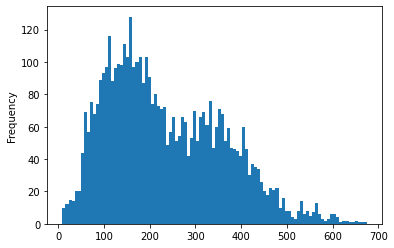

In [43]:
transactions_per_account.sort_values().plot.hist(bins=100)

In [44]:
accounts = df['account_id']
#df = df.drop(columns=['account_id'])
df

,account_id,date_dayofweek,date_day,date_week,date_month,date_year,date_days_from_last_trans,date,type_credit,type_withdrawal,...,op_withdrawal_in_cash,amount,balance,k_symbol_household,k_symbol_statement,k_symbol_loan,k_symbol_insurance,k_symbol_pension,k_symbol_credited_interest,k_symbol_sanction_interest
trans_id,,,,,,,,,,,,,,,,,,,,,
1,1,4,24,12,3,2,0,1995-03-24,1,0,...,0,1000,1000,0,0,0,0,0,0,0
5,1,3,13,15,4,2,20,1995-04-13,1,0,...,0,3679,4679,0,0,0,0,0,0,0
199,1,6,23,16,4,2,10,1995-04-23,1,0,...,0,12600,17279,0,0,0,0,0,0,0
3530438,1,6,30,17,4,2,7,1995-04-30,1,0,...,0,19,17298,0,0,1,0,0,0,0
6,1,5,13,19,5,2,13,1995-05-13,1,0,...,0,3679,20977,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431284,11382,2,2,49,12,5,2,1998-12-02,0,1,...,1,25600,41114,0,0,0,0,0,0,0
3431109,11382,3,10,50,12,5,8,1998-12-10,1,0,...,0,46248,87362,0,0,0,0,0,0,0
3431152,11382,4,25,52,12,5,15,1998-12-25,0,1,...,1,6300,81062,0,0,0,0,0,0,0


We're going to keep the account_id field in order to make consecutive transactions easier to group.

In [45]:
import pickle 

with open('crafted/df_cleaned.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
df.shape


(1056320, 25)

In [47]:
orig_df = pd.read_csv('transactions.csv', index_col=['trans_id'], parse_dates=['date'])
orig_df

/home/one/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/one/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,account_id,date,type,operation,amount,balance,k_symbol,bank,account
trans_id,,,,,,,,,
1,1,1995-03-24,PRIJEM,VKLAD,1000,1000,NaN,NaN,NaN
5,1,1995-04-13,PRIJEM,PREVOD Z UCTU,3679,4679,NaN,AB,41403269.0
6,1,1995-05-13,PRIJEM,PREVOD Z UCTU,3679,20977,NaN,AB,41403269.0
7,1,1995-06-13,PRIJEM,PREVOD Z UCTU,3679,26835,NaN,AB,41403269.0
8,1,1995-07-13,PRIJEM,PREVOD Z UCTU,3679,30415,NaN,AB,41403269.0
...,...,...,...,...,...,...,...,...,...
3682983,10451,1998-08-31,PRIJEM,NaN,62,17300,UROK,NaN,NaN
3682984,10451,1998-09-30,PRIJEM,NaN,49,13442,UROK,NaN,NaN
3682985,10451,1998-10-31,PRIJEM,NaN,34,10118,UROK,NaN,NaN


In [48]:
from Cleaner import Cleaner

cleaner = Cleaner(orig_df)
cleaner.clean_fields()
cleaner.save_cleaned_df(path='./', filename='df_cleaned2')

Cleaned dataframe saved successfully!


In [49]:
with open('df_cleaned2.pickle', 'rb') as handle:
    df2 = pickle.load(handle)

In [53]:
cols1 = df.columns.tolist()
cols2 = df2.columns.tolist()
set(cols1)==set(cols2)

True

In [64]:
df = df.sort_index()
df

,account_id,date_dayofweek,date_day,date_week,date_month,date_year,date_days_from_last_trans,date,type_credit,type_withdrawal,...,op_withdrawal_in_cash,amount,balance,k_symbol_household,k_symbol_statement,k_symbol_loan,k_symbol_insurance,k_symbol_pension,k_symbol_credited_interest,k_symbol_sanction_interest
trans_id,,,,,,,,,,,,,,,,,,,,,
1,1,4,24,12,3,2,0,1995-03-24,1,0,...,0,1000,1000,0,0,0,0,0,0,0
5,1,3,13,15,4,2,20,1995-04-13,1,0,...,0,3679,4679,0,0,0,0,0,0,0
6,1,5,13,19,5,2,13,1995-05-13,1,0,...,0,3679,20977,0,0,0,0,0,0,0
7,1,1,13,24,6,2,13,1995-06-13,1,0,...,0,3679,26835,0,0,0,0,0,0,0
8,1,3,13,28,7,2,13,1995-07-13,1,0,...,0,3679,30415,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3682983,10451,0,31,36,8,5,0,1998-08-31,1,0,...,0,62,17300,0,0,1,0,0,0,0
3682984,10451,2,30,40,9,5,0,1998-09-30,1,0,...,0,49,13442,0,0,1,0,0,0,0
3682985,10451,5,31,44,10,5,0,1998-10-31,1,0,...,0,34,10118,0,0,1,0,0,0,0


In [75]:
for col in df.columns:
    sums = (df[col] != df2[col]).sum()
    if sums != 0:
        print(f'{col}: {sums}')

date_days_from_last_trans: 1032017


In [76]:
df['date_days_from_last_trans']

trans_id
1           0
5          20
6          13
7          13
8          13
           ..
3682983     0
3682984     0
3682985     0
3682986     0
3682987     0
Name: date_days_from_last_trans, Length: 1056320, dtype: int64

In [78]:
df2

,account_id,date_days_from_last_trans,date_year,date_month,date_week,date_day,date_dayofweek,date,type_credit,type_withdrawal,...,op_withdrawal_in_cash,amount,balance,k_symbol_household,k_symbol_statement,k_symbol_loan,k_symbol_insurance,k_symbol_pension,k_symbol_credited_interest,k_symbol_sanction_interest
trans_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,2,3,12,24,4,1995-03-24,1,0,...,0,1000,1000,0,0,0,0,0,0,0
5,1,20,2,4,15,13,3,1995-04-13,1,0,...,0,3679,4679,0,0,0,0,0,0,0
6,1,30,2,5,19,13,5,1995-05-13,1,0,...,0,3679,20977,0,0,0,0,0,0,0
7,1,31,2,6,24,13,1,1995-06-13,1,0,...,0,3679,26835,0,0,0,0,0,0,0
8,1,30,2,7,28,13,3,1995-07-13,1,0,...,0,3679,30415,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3682983,10451,31,5,8,36,31,0,1998-08-31,1,0,...,0,62,17300,0,0,1,0,0,0,0
3682984,10451,30,5,9,40,30,2,1998-09-30,1,0,...,0,49,13442,0,0,1,0,0,0,0
3682985,10451,31,5,10,44,31,5,1998-10-31,1,0,...,0,34,10118,0,0,1,0,0,0,0
